# Tutorial with 1d advection equation

Code pipeline from the PNAS 2020 paper by Jiawei Zhuang et al. 

In [1]:
# %%capture
# !pip install -U numpy==1.18.5
# !pip install h5py==2.10.0

In [2]:
'Comment above cell and restart and run all before'

'Comment above cell and restart and run all before'

In [3]:
'Check numpys version BEFORE and AFTER runtime restart'
import numpy as np
print(np.__version__)

1.18.5


# Setup

In [4]:
%%capture
!git clone https://github.com/aditya5252/Multiprocessor_Advection_.git
!pip install git+https://github.com/JiaweiZhuang/data-driven-pdes@fix-beam
%tensorflow_version 1.x
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from google.colab import files  # colab-specific utilities; comment out when running locally

tf.enable_eager_execution()

tf.__version__, tf.keras.__version__
import xarray
from datadrivenpdes.core import grids
from datadrivenpdes.core import integrate
from datadrivenpdes.core import models
from datadrivenpdes.core import tensor_ops
from datadrivenpdes.advection import equations as advection_equations
from datadrivenpdes.pipelines import model_utils

# Define Split Simulation grids

In [5]:
# we mostly run simulation on coarse grid
# the fine grid is only for obtaining training data and generate the reference "truth"

numPE=4
grid_length = 2*np.pi/numPE
fine_grid_resolution = 256/numPE
coarse_grid_resolution = 256/numPE

assert fine_grid_resolution % coarse_grid_resolution == 0

# 1d domain, so only 1 point along y dimension

fine_grid = grids.Grid(
    size_x=fine_grid_resolution, size_y=1, 
    step=grid_length/fine_grid_resolution
    )

coarse_grid = grids.Grid(
    size_x=coarse_grid_resolution, size_y=1, 
    step=grid_length/coarse_grid_resolution
    )

x_fine, _ = fine_grid.get_mesh()
x_coarse, _ = coarse_grid.get_mesh()

x_fine.shape, x_coarse.shape

((64, 1), (64, 1))

# Define functions

In [6]:
'Find dt for Advection-1d equation'
def _dx_dt(data,adv_coff):
    dx=2*np.pi/(data.shape[1])
    return dx,dx*0.08/adv_coff

'Plot time propagation of dataset'
def plot_time_prop(data,t0,t1,t2):
  plt.plot(data[t0],label=f'Max_{t0}={data[t0].max()}')
  plt.plot(data[t1],label=f'Max_{t1}={data[t1].max()}')
  plt.plot(data[t2],label=f'Max_{t2}={data[t2].max()}')
  plt.legend()

'Create initial_state dictionary from dataset'
def create_init_state_from_2d_data(data):
  c_init=data[0][np.newaxis,:,np.newaxis]

  initial_state_obj = {
      'concentration': c_init.astype(np.float32),  # tensorflow code expects float32
      'x_velocity': np.ones(c_init.shape, np.float32) * 1.0,
      'y_velocity': np.zeros(c_init.shape, np.float32)
  }

  for k, v in initial_state_obj.items():
    print(k, v.shape)   # (sample, x, y)
  return initial_state_obj

'Create xarray DatArray from integrated dictionary'
def wrap_as_xarray(integrated):
  dr = xarray.DataArray(
      integrated['concentration'].numpy().squeeze(-1),
      dims = ('time', 'sample', 'x'),
      coords = {'time': time_steps, 'x': x_coarse.squeeze()}
  )
  return dr

In [7]:
# This data-generation code is a bit involved, mostly because we use multi-step loss function.
# To produce large training data in parallel, refer to the create_training_data.py script in source code.

def reference_solution(initial_state_fine, fine_grid, coarse_grid, 
                       coarse_time_steps=256):
  'What does this function do'
  'Runs high-accuracy model at high-resolution'
  'smaller dx, => More Nx   => More Nt'
  'Subsample with  subsampling_factor=Resamplingfactor '
  'High accuracy data achieved on a coarse grid'
  'So essentially obtain coarse-grained, HIGH-ACCURACY, GROUND TRUTH data'
  'Return dict of items'


  'For my simple use-case , Resamplingfactor = 1 '
  'Hence, given sync_data dataset(128 x 32)'
  'sync_data dataset itself is taken as the ground truth'
  'Hence we do not need this function to obtain Ground truth data '

  # use high-order traditional scheme as reference model
  equation = advection_equations.VanLeerAdvection(cfl_safety_factor=0.08)
  key_defs = equation.key_definitions

  # reference model runs at high resolution
  model = models.FiniteDifferenceModel(equation, fine_grid)
  
  # need 8x more time steps for 8x higher resolution to satisfy CFL
  coarse_ratio = fine_grid.size_x // coarse_grid.size_x
  steps = np.arange(0, coarse_time_steps*coarse_ratio+1, coarse_ratio)

  # solve advection at high resolution
  integrated_fine = integrate.integrate_steps(model, initial_state_fine, steps)

  # regrid to coarse resolution
  integrated_coarse = tensor_ops.regrid(
      integrated_fine, key_defs, fine_grid, coarse_grid)
  
  return integrated_coarse


In [8]:
def ground_dict_from_data(data):
  conc_ground=tf.convert_to_tensor(data[:,np.newaxis,:,np.newaxis], dtype=tf.float32, dtype_hint=None, name=None)
  ground_soln_dict = {
      'concentration': conc_ground,  # tensorflow code expects float32
      'x_velocity': tf.ones_like(conc_ground, dtype=None, name=None) * 1.0,
      'y_velocity': tf.zeros_like(conc_ground, dtype=None, name=None)
  }
  for k, v in ground_soln_dict.items():
    print(k, v.shape)   # (sample, x, y)
  return ground_soln_dict

def make_train_data(integrated_coarse, coarse_time_steps=256, example_time_steps=4):
  # we need to re-format data so that single-step input maps to multi-step output

  # remove the last several time steps, as training input
  train_input = {k: v[:-example_time_steps] for k, v in integrated_coarse.items()}

  # merge time and sample dimension as required by model
  n_time, n_sample, n_x, n_y = train_input['concentration'].shape
  for k in train_input:
    train_input[k] = tf.reshape(train_input[k], [n_sample * n_time, n_x, n_y])

  print('\n train_input shape:')
  for k, v in train_input.items():
    print(k, v.shape)  # (merged_sample, x, y)

  # pick the shifted time series, as training output

  output_list = []
  for shift in range(1, example_time_steps+1):
    # output time series, starting from each single time step
    output_slice = integrated_coarse['concentration'][shift:coarse_time_steps - example_time_steps + shift + 1] 
    # merge time and sample dimension as required by training
    n_time, n_sample, n_x, n_y = output_slice.shape
    output_slice = tf.reshape(output_slice, [n_sample * n_time, n_x, n_y])
    output_list.append(output_slice)

  train_output = tf.stack(output_list, axis=1)  # concat along shift_time dimension, after sample dimension

  print('\n train_output shape:',  train_output.shape)  # (merged_sample, shift_time, x, y)

  # sanity check on shapes
  assert train_output.shape[0] == train_input['concentration'].shape[0]  # merged_sample
  assert train_output.shape[2] == train_input['concentration'].shape[1]  # x
  assert train_output.shape[3] == train_input['concentration'].shape[2]  # y
  assert train_output.shape[1] == example_time_steps

  return train_input, train_output

# Load and Plot datasets

In [66]:
wave_path='/content/Multiprocessor_Advection_/Datasets/Wave'
data0=np.loadtxt(wave_path+'/Sync/Experiment2/WaveSync256_Amp1')
# data1=np.loadtxt(wave_path+'/Sync/Experiment2/WaveSync256_Amp2')
_,dt=_dx_dt(data0,1.)
# time_steps=np.arange(3200)

In [67]:
data0_list=np.split(data0,4,1)
# data1_list=np.split(data1,4,1)

# Time propagation of Original sub-grid

Text(0.5, 1.0, 'Original Sync 0 Advected in time')

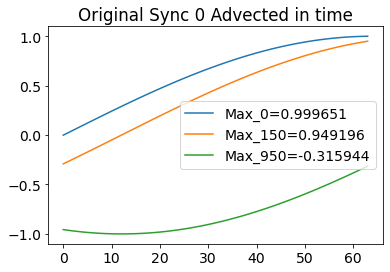

In [69]:
'Time propagation of Original dataset'
plot_time_prop(data0_list[0],0,150,950)
plt.title('Original Sync 0 Advected in time')

In [70]:
sync_data_old=data0_list[0]
one_arr=np.ones_like(sync_data_old)
boundary_arr=np.zeros_like(sync_data_old)
boundary_arr[:,0]=1.
boundary_arr[:,-1]=1.
del_arr=boundary_arr+one_arr
sync_data=np.multiply(del_arr,sync_data_old)

Text(0.5, 1.0, 'Modified Sync 0 Advected in time')

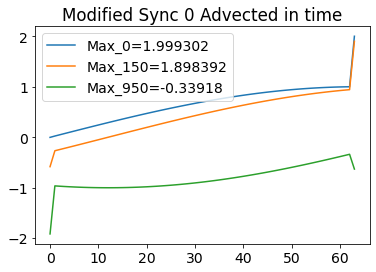

In [71]:
'Time propagation of Modified dataset'
plot_time_prop(sync_data,0,150,950)
plt.title('Modified Sync 0 Advected in time')

In [ ]:
sync_data_old=sync_data_full[:,0:x_fine.shape[0]]
sync1_old=sync1_full[:,0:x_fine.shape[0]]

# Create Iniital state from Modified data

In [64]:
'Data-0 Proc=0'
'Create initial state from data'
initial_state=create_init_state_from_2d_data(sync_data)

concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)


# Define model_nn and equation

In [97]:
model_nn = models.PseudoLinearModel(
    advection_equations.FiniteDifferenceAdvection(0.08), 
    coarse_grid,
    num_time_steps=10,  # multi-step loss function
    stencil_size=3, kernel_size=(3, 1), num_layers=4, filters=32,
    constrained_accuracy_order=1, 
    learned_keys = {'concentration_x', 'concentration_y'},  # finite volume view, use edge concentration
    activation='relu',
)
model_nn.learned_keys, model_nn.fixed_keys

## CHECK VALUE OF dt IN model_nn
advection_equations.FiniteDifferenceAdvection(0.08).get_time_step(coarse_grid,1.) == dt

True

# Untrained Model for time-propagation

In [98]:
tf.random.set_random_seed(0)
time_steps=np.arange(3200)
%time integrated_untrained = integrate.integrate_steps(model_nn, initial_state, time_steps)
# %time integrated_untrained2 = integrate.integrate_steps(model_nn, initial_state2, time_steps)

CPU times: user 26.7 s, sys: 118 ms, total: 26.8 s
Wall time: 26.7 s


In [99]:
'FOR MODIFIED DATASET'

'FOR MODIFIED DATASET'

## Untrained Model time-propagation

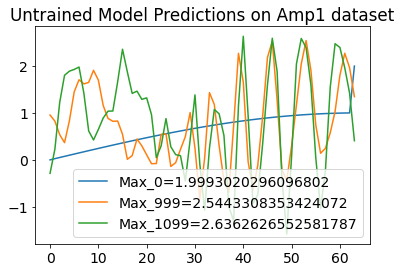

In [100]:
plot_time_prop(integrated_untrained['concentration'].numpy().squeeze(),0,999,1099)
plt.title('Untrained Model Predictions on Amp1 dataset')
plt.show()

## Ideal time-propagation

Text(0.5, 1.0, 'Modified Sync 0 Advected in time')

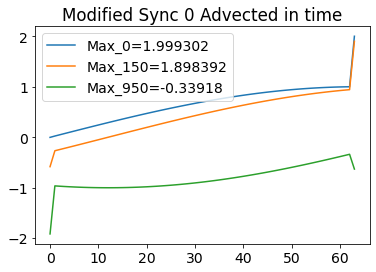

In [101]:
'Time propagation of Modified dataset'
plot_time_prop(sync_data,0,150,950)
plt.title('Modified Sync 0 Advected in time')

## Time-propagation Near and Far away times

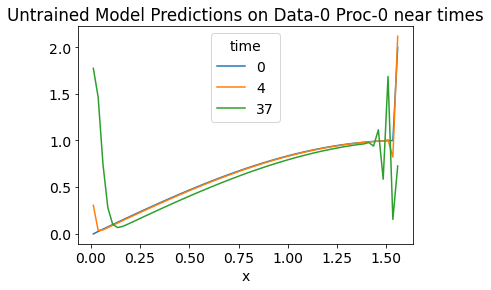

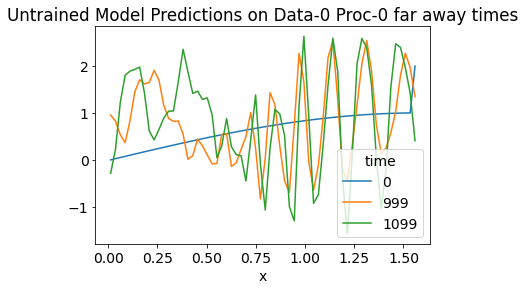

In [102]:
dr_UT1 = wrap_as_xarray(integrated_untrained)
dr_UT1.isel(time=[0,4,37], sample=[0]).plot( hue='time')
plt.title('Untrained Model Predictions on Data-0 Proc-0 near times')
plt.show()
dr_UT1.isel(time=[0,999,1099], sample=[0]).plot( hue='time')
plt.title('Untrained Model Predictions on Data-0 Proc-0 far away times')
plt.show()

# Create Training Data

In [105]:
ground_soln_dict=ground_dict_from_data(sync_data)
train_input, train_output = make_train_data(ground_soln_dict,sync_data.shape[0]-1, 10)

concentration (1019, 1, 64, 1)
x_velocity (1019, 1, 64, 1)
y_velocity (1019, 1, 64, 1)

 train_input shape:
concentration (1009, 64, 1)
x_velocity (1009, 64, 1)
y_velocity (1009, 64, 1)

 train_output shape: (1009, 10, 64, 1)


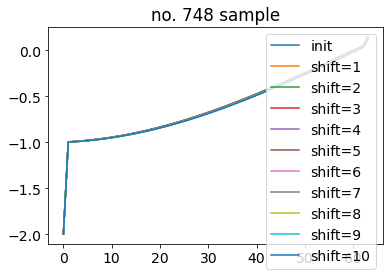

In [106]:
# make sure that single-step input corresponds to multi-step (advected) output
i_sample = 748  # any number between 0 and train_output.shape[0]
plt.plot(train_input['concentration'][i_sample].numpy(), label='init')
for shift in range(train_output.shape[1]):
  plt.plot(train_output[i_sample, shift].numpy(), label=f'shift={shift+1}')

plt.title(f'no. {i_sample} sample')
plt.legend()

# Train neural net model

In [107]:
%%time 
# same as training standard Keras model
model_nn.compile(
    optimizer='adam', loss='mae'
    )

tf.random.set_random_seed(42)
np.random.seed(42)

history = model_nn.fit(
    train_input, train_output, epochs=30, batch_size=64, 
    verbose=1, shuffle=True
    )

Train on 1009 samples
Epoch 1/30
1009/1009 [==============================] - 7s 6ms/sample - loss: 0.0113
Epoch 2/30
1009/1009 [==============================] - 3s 3ms/sample - loss: 0.0055
Epoch 3/30
1009/1009 [==============================] - 4s 4ms/sample - loss: 0.0027
Epoch 4/30
1009/1009 [==============================] - 3s 3ms/sample - loss: 0.0014
Epoch 5/30
1009/1009 [==============================] - 3s 3ms/sample - loss: 9.9169e-04
Epoch 6/30
1009/1009 [==============================] - 3s 3ms/sample - loss: 7.2680e-04
Epoch 7/30
1009/1009 [==============================] - 3s 3ms/sample - loss: 7.4973e-04
Epoch 8/30
1009/1009 [==============================] - 3s 3ms/sample - loss: 4.9448e-04
Epoch 9/30
1009/1009 [==============================] - 4s 3ms/sample - loss: 4.5019e-04
Epoch 10/30
1009/1009 [==============================] - 3s 3ms/sample - loss: 4.9738e-04
Epoch 11/30
1009/1009 [==============================] - 3s 3ms/sample - loss: 4.7068e-04
Epoch 12/30
1

# Training parameters Plot

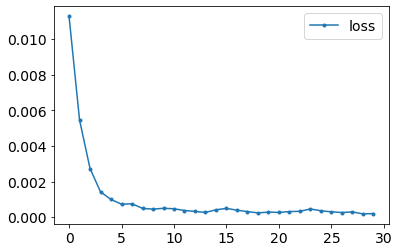

In [108]:
df_history = pd.DataFrame(history.history)
df_history.plot(marker='.')

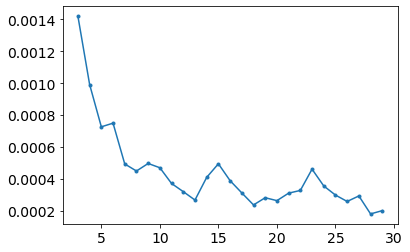

In [109]:
df_history['loss'][3:].plot(marker='.')
# might not converged yet

# Trained Model for time-propagation

In [110]:
# tf.random.set_random_seed(0)
time_steps=np.arange(3200)
%time integrated_trained = integrate.integrate_steps(model_nn, initial_state, time_steps)
# %time integrated_untrained2 = integrate.integrate_steps(model_nn, initial_state2, time_steps)

CPU times: user 28.8 s, sys: 112 ms, total: 28.9 s
Wall time: 29.3 s


In [ ]:
'FOR MODIFIED DATASET'

'FOR MODIFIED DATASET'

## Trained Model time-propagation

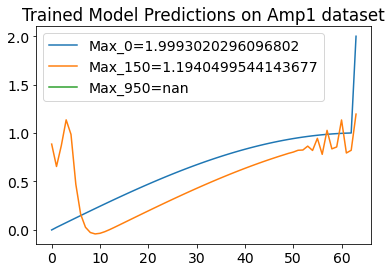

In [114]:
plot_time_prop(integrated_trained['concentration'].numpy().squeeze(),0,150,950)
plt.title('Trained Model Predictions on Amp1 dataset')
plt.show()

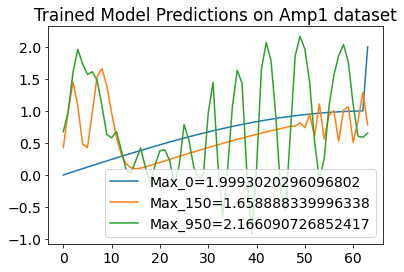

In [116]:
plot_time_prop(integrated_untrained['concentration'].numpy().squeeze(),0,150,950)
plt.title('Trained Model Predictions on Amp1 dataset')
plt.show()

## Ideal time-propagation

Text(0.5, 1.0, 'Modified Sync 0 Advected in time')

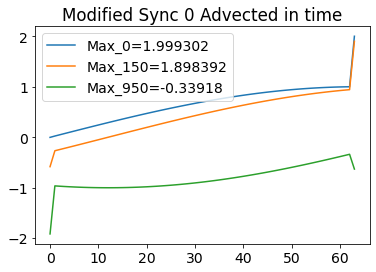

In [117]:
'Time propagation of Modified dataset'
plot_time_prop(sync_data,0,150,950)
plt.title('Modified Sync 0 Advected in time')

## Time-propagation Near and Far away times

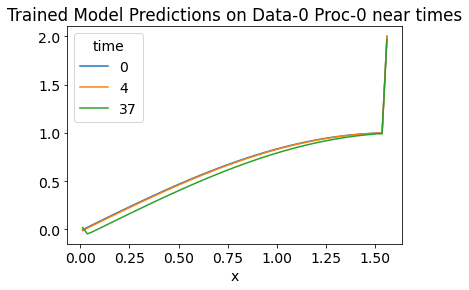

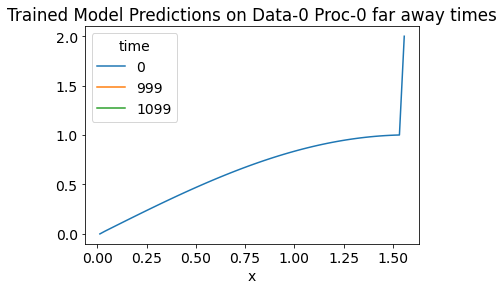

In [118]:
dr_UT1 = wrap_as_xarray(integrated_trained)
dr_UT1.isel(time=[0,4,37], sample=[0]).plot( hue='time')
plt.title('Trained Model Predictions on Data-0 Proc-0 near times')
plt.show()
dr_UT1.isel(time=[0,999,1099], sample=[0]).plot( hue='time')
plt.title('Trained Model Predictions on Data-0 Proc-0 far away times')
plt.show()

# Infer sync_data, sync1 on trained model

CPU times: user 26.8 s, sys: 86.3 ms, total: 26.9 s
Wall time: 26.8 s


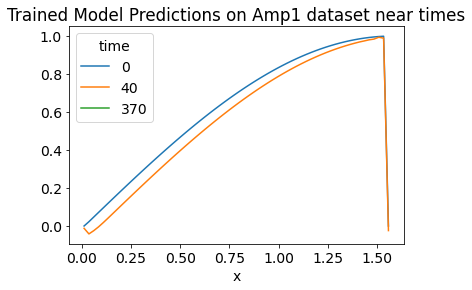

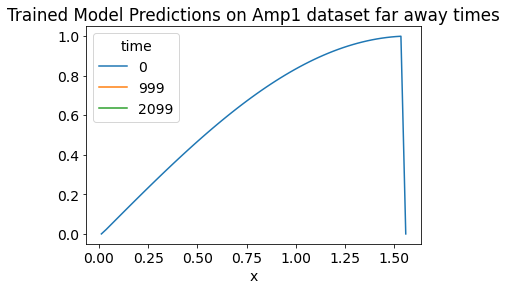

In [ ]:
'INFER ON sync_data'
time_steps=np.arange(3200)
%time integrated_trained = integrate.integrate_steps(model_nn, initial_state, time_steps)
dr_T = wrap_as_xarray(integrated_trained)
dr_T.isel(time=[0,40,370], sample=[0]).plot( hue='time')
plt.title('Trained Model Predictions on Amp1 dataset near times')
plt.show()
dr_T.isel(time=[0,999,2099], sample=[0]).plot( hue='time')
plt.title('Trained Model Predictions on Amp1 dataset far away times')
plt.show()

CPU times: user 27.1 s, sys: 79.9 ms, total: 27.2 s
Wall time: 27.2 s


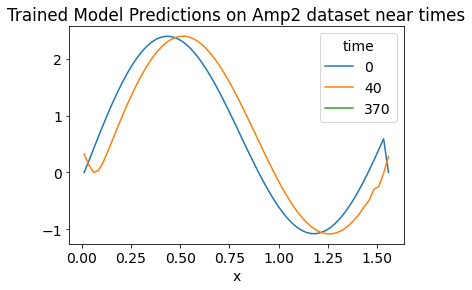

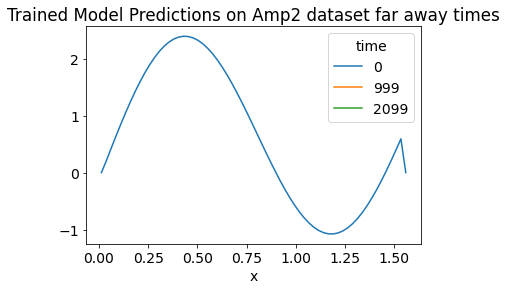

In [ ]:
'INFER ON sync1'
time_steps=np.arange(3200)
%time integrated_trained2 = integrate.integrate_steps(model_nn, initial_state2, time_steps)
dr_T2 = wrap_as_xarray(integrated_trained2)
dr_T2.isel(time=[0,40,370], sample=[0]).plot( hue='time')
plt.title('Trained Model Predictions on Amp2 dataset near times')
plt.show()
dr_T2.isel(time=[0,999,2099], sample=[0]).plot( hue='time')
plt.title('Trained Model Predictions on Amp2 dataset far away times')
plt.show()

# Save trained model

In [ ]:
# os.chdir(os.path.expanduser("~"))

In [ ]:
os.getcwd()

'/content'

In [ ]:
model_utils.save_weights(model_nn, 'weights_wave_2_256.h5')
# os.chdir('../../../../Models/Experiment1')

In [ ]:
a

# Or directly load trained model

Need to manually upload weights as Colab local file

In [ ]:
model_utils.load_weights(model_nn,'weights_wave_0_32.h5')

# Integrate trained model

In [ ]:
# time_steps

array([   0,    1,    2, ..., 1197, 1198, 1199])

In [ ]:
%time integrated_nn = integrate.integrate_steps(model_nn, initial_state, time_steps)

CPU times: user 8.13 s, sys: 36.5 ms, total: 8.16 s
Wall time: 8.15 s


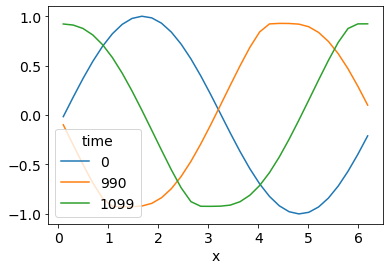

In [ ]:
dr_2nd = wrap_as_xarray(integrated_2nd)
dr_2nd.isel(time=[0,990,1099], sample=[0]).plot( hue='time')

Text(0.5, 1.0, 'Trained Model Predictions')

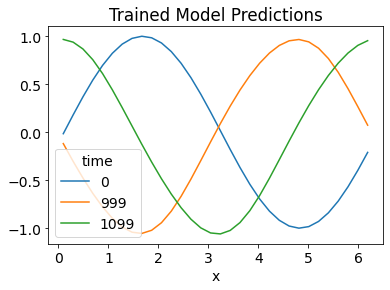

In [ ]:
# integrated_untrained['concentration'][8999]
dr_trained = wrap_as_xarray(integrated_untrained)
# plt.figure(figsize=(11,9))
dr_trained.isel(time=[0,999,1099], sample=[0]).plot( hue='time')
plt.title('Trained Model Predictions')


In [ ]:
dr_nn = wrap_as_xarray(integrated_nn)
dr_nn.sizes

Frozen({'time': 257, 'sample': 30, 'x': 32})

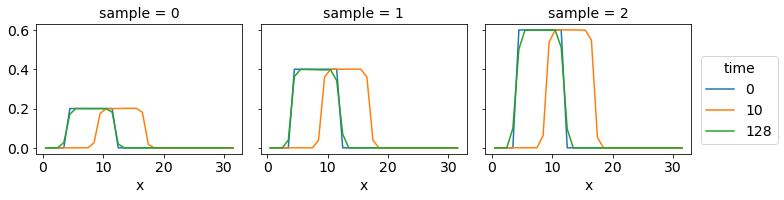

In [ ]:
dr_nn.isel(time=[0, 10, 128], sample=[4, 10, 16]).plot(col='sample', hue='time')
# much better than traditional finite difference scheme

## Evaluate accuracy on training set

Here just test on training data. Next section makes new test data.

In [ ]:
dr_ref = wrap_as_xarray(integrated_ref)  # reference "truth"

dr_all_train = xarray.concat([dr_nn, dr_2nd, dr_1st, dr_ref], dim='model')
dr_all_train.coords['model'] = ['nn', '2nd', '1st', 'ref']

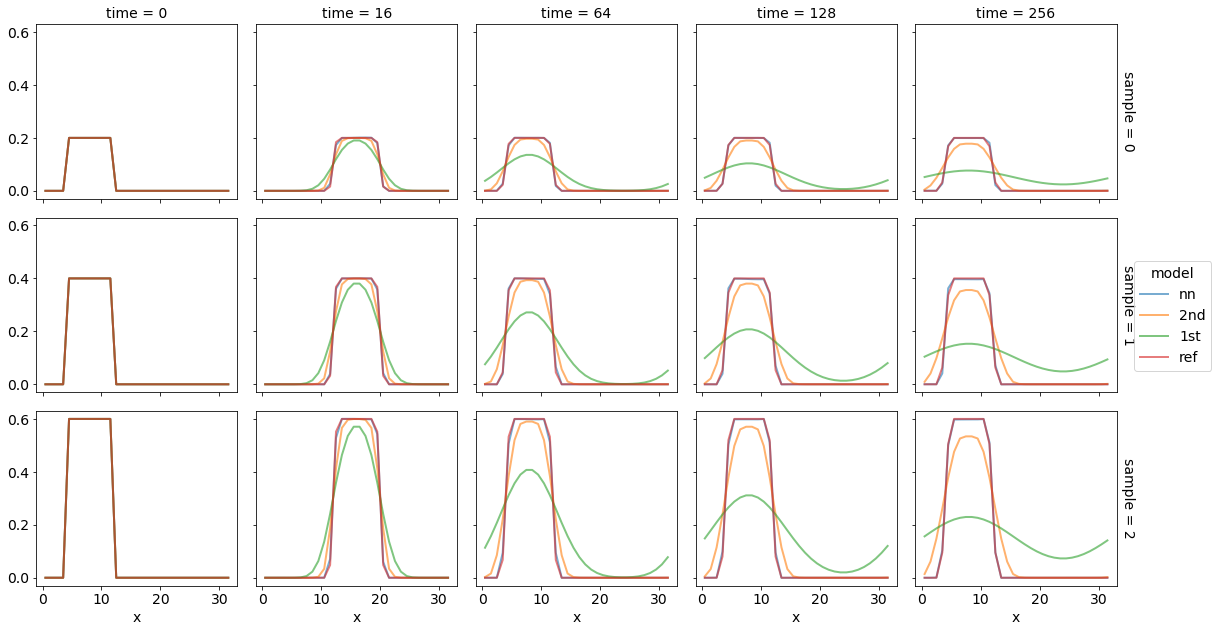

In [ ]:
(dr_all_train.isel(time=[0, 16, 64, 128, 256], sample=[4, 10, 16])
.plot(hue='model', col='time', row='sample', alpha=0.6, linewidth=2)
)
# neural net model (blue line) almost overlaps with reference truth (red line); so lines are hard to see clearly

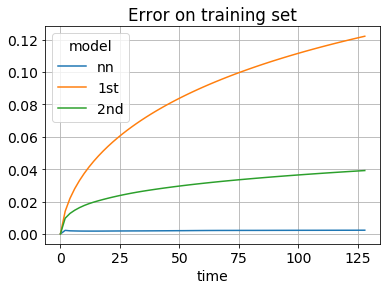

In [ ]:
(
  (dr_all_train.sel(model=['nn', '1st', '2nd']) - dr_all_train.sel(model='ref'))
  .pipe(abs).mean(dim=['x', 'sample'])  # mean absolute error
  .isel(time=slice(0, 129, 2))  # the original error series oscillates between odd & even steps, because CFL=0.5
  .plot(hue='model')
)
plt.title('Error on training set')
plt.grid()

# Prediction on new test data

In [ ]:
np.random.seed(41)
height_list_test = np.random.uniform(0.1, 0.9, size=10) 
# width_list_test = np.random.uniform(1/16, 1/4, size=3)  
# doesn't make sense to randomly sample widths of square waves, as a square has to align with grid

c_init_test = make_multi_square(
  x_coarse,
  height_list = height_list_test,
  width_list = width_list  # just use width in training set
)

c_init_test.shape  # (sample, x, y)

(30, 32, 1)

In [ ]:
height_list_test # , width_list_test

array([0.3007389 , 0.13687666, 0.64145299, 0.13477559, 0.19313896,
       0.58309255, 0.25274453, 0.63481257, 0.83395828, 0.43502407])

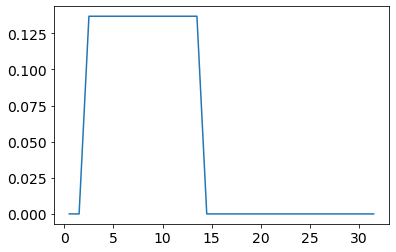

In [ ]:
plt.plot(x_coarse, c_init_test[5])

In [ ]:
initial_state_test = {
    'concentration': c_init_test.astype(np.float32),  # tensorflow code expects float32
    'x_velocity': np.ones(c_init_test.shape, np.float32) * 1.0,
    'y_velocity': np.zeros(c_init_test.shape, np.float32)
}

for k, v in initial_state_test.items():
  print(k, v.shape)

concentration (30, 32, 1)
x_velocity (30, 32, 1)
y_velocity (30, 32, 1)


In [ ]:
%time dr_nn_test = wrap_as_xarray(integrate.integrate_steps(model_nn, initial_state_test, time_steps))

%time dr_1st_test = wrap_as_xarray(integrate.integrate_steps(model_1st, initial_state_test, time_steps))

%time dr_2nd_test = wrap_as_xarray(integrate.integrate_steps(model_2nd, initial_state_test, time_steps))

CPU times: user 3.2 s, sys: 45.9 ms, total: 3.24 s
Wall time: 3.07 s
CPU times: user 478 ms, sys: 0 ns, total: 478 ms
Wall time: 479 ms
CPU times: user 2.23 s, sys: 0 ns, total: 2.23 s
Wall time: 2.24 s


(0, 1)

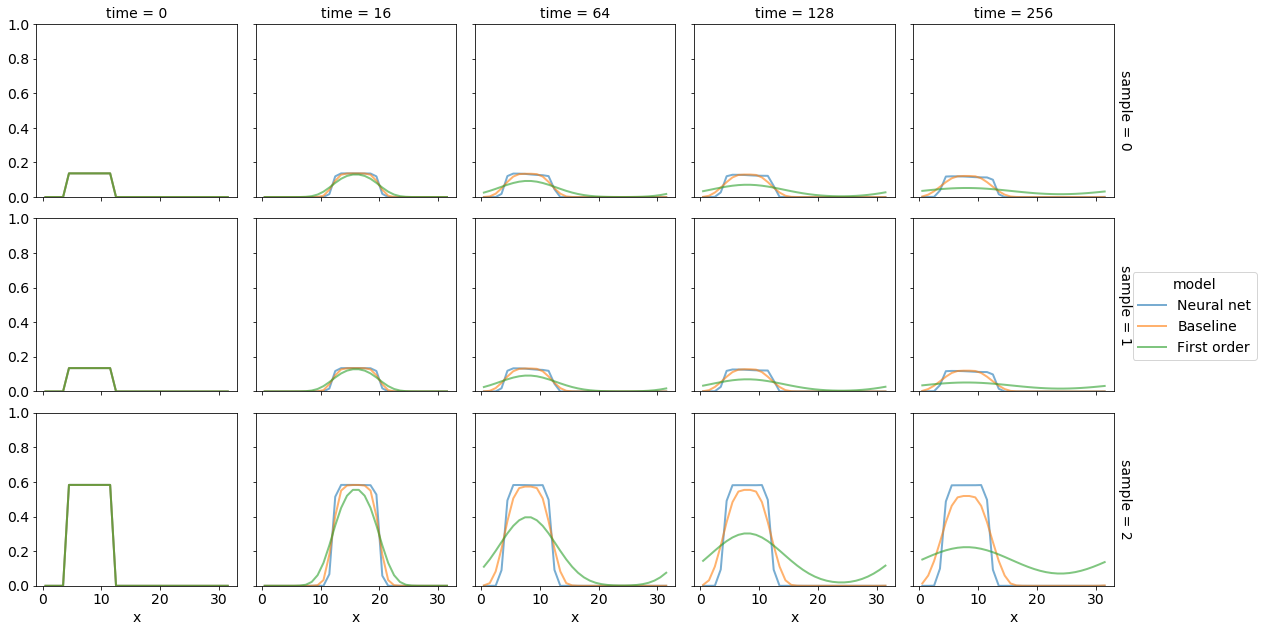

In [ ]:
dr_sol_test = xarray.concat([dr_nn_test, dr_2nd_test, dr_1st_test], dim='model')
dr_sol_test.coords['model'] = ['Neural net', 'Baseline', 'First order']

(dr_sol_test.isel(time=[0, 16, 64, 128, 256], sample=[4, 10, 16])
.plot(hue='model', col='time', row='sample', alpha=0.6, linewidth=2)
)

plt.ylim(0, 1)

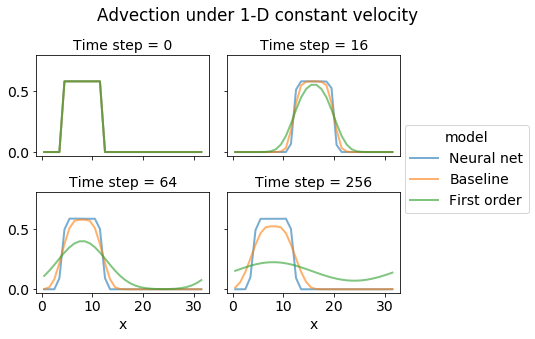

In [ ]:
(dr_sol_test.isel(time=[0, 16, 64, 256], sample=16).rename({'time': 'Time step'})
.plot(hue='model', col='Time step', alpha=0.6, col_wrap=2, linewidth=2, figsize=[6, 4.5], ylim=[None, 0.8])
)

plt.suptitle('Advection under 1-D constant velocity', y=1.05)
plt.savefig('1d-test-sample.png', dpi=288, bbox_inches='tight')

In [ ]:
# files.download('1d-test-sample.png')

### Reference solution for test set

In [ ]:
# need to re-evaluate initial condition on high-resolution grid

c_init_fine_test = make_multi_square(
  x_fine,
  height_list = height_list_test,
  width_list = width_list
)

initial_state_fine_test = {
    'concentration': c_init_fine_test.astype(np.float32),  # tensorflow code expects float32
    'x_velocity': np.ones(c_init_fine_test.shape, np.float32) * 1.0,
    'y_velocity': np.zeros(c_init_fine_test.shape, np.float32)
}

%time integrated_ref_test = reference_solution(initial_state_fine_test, fine_grid, coarse_grid)

dr_ref_test = wrap_as_xarray(integrated_ref_test)  # reference "truth"

CPU times: user 20.3 s, sys: 0 ns, total: 20.3 s
Wall time: 20.4 s


In [ ]:
dr_all_test = xarray.concat([dr_nn_test, dr_2nd_test, dr_1st_test, dr_ref_test], dim='model')
dr_all_test.coords['model'] = ['Neural net', 'Baseline', 'First order', 'Reference']

(0, 1)

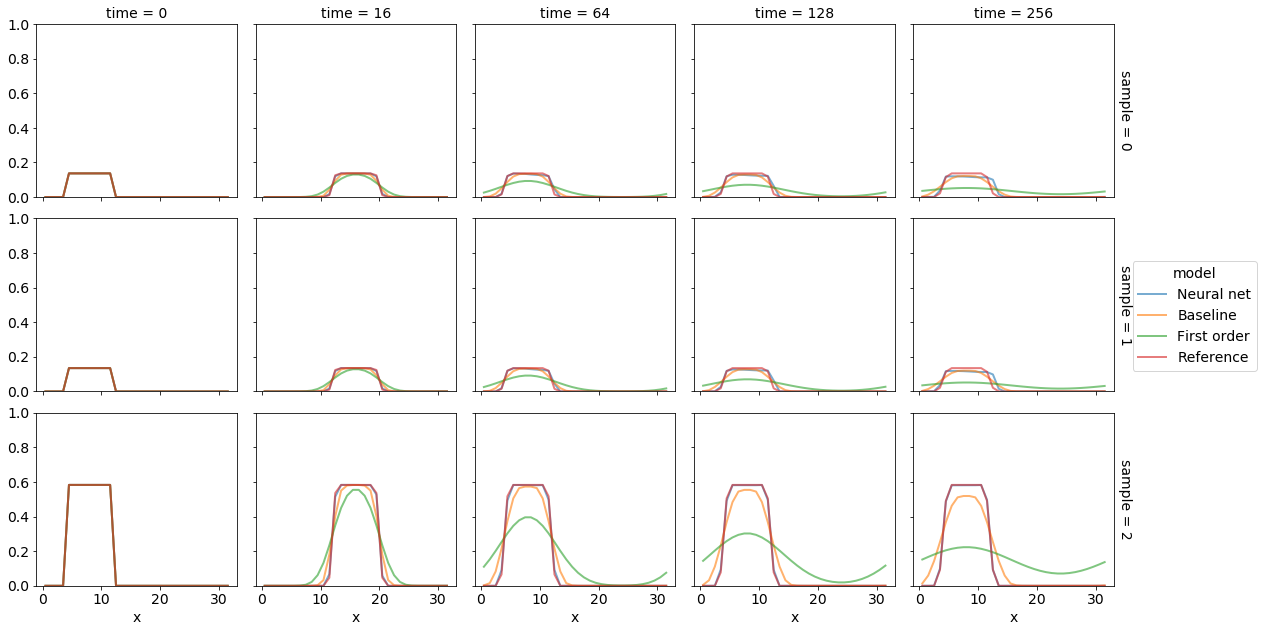

In [ ]:
(dr_all_test.isel(time=[0, 16, 64, 128, 256], sample=[4, 10, 16])
.plot(hue='model', col='time', row='sample', alpha=0.6, linewidth=2)
)

plt.ylim(0, 1)

Text(0.5, 1.05, 'Advection under 1-D constant velocity')

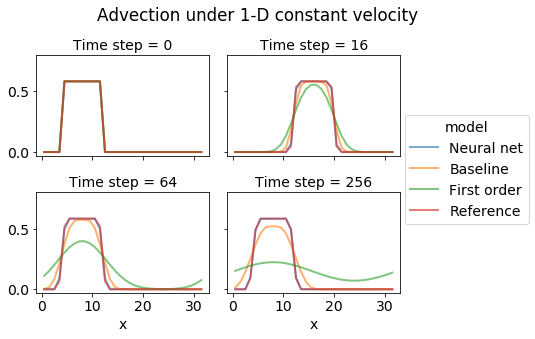

In [ ]:
(dr_all_test.isel(time=[0, 16, 64, 256], sample=16).rename({'time': 'Time step'})
.plot(hue='model', col='Time step', alpha=0.6, col_wrap=2, linewidth=2, figsize=[6, 4.5], ylim=[None, 0.8])
)

plt.suptitle('Advection under 1-D constant velocity', y=1.05)
# plt.savefig('1d-test-sample.png', dpi=288, bbox_inches='tight')

## Plot test accuracy

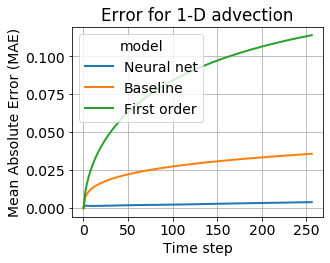

In [ ]:
(
  (dr_all_test.sel(model=['Neural net', 'Baseline', 'First order']) - dr_all_test.sel(model='Reference'))
  .pipe(abs).mean(dim=['x', 'sample'])  # mean absolute error
  .isel(time=slice(0, 257, 2))  # the original error series oscillates between odd & even steps, because CFL=0.5
  .plot(hue='model', figsize=[4.5, 3.5], linewidth=2.0)
)
plt.title('Error for 1-D advection')
plt.xlabel('Time step')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid()
plt.xticks(range(0, 257, 50))
plt.savefig('1d-test-mae.png', dpi=288, bbox_inches='tight')

In [ ]:
# files.download('1d-test-mae.png')

# Out-of-sample prediction

In [ ]:
def make_gaussian(x, height=1.0, center=0.25, width=0.1):
  """
  Args:
    x: Numpy array. Shape should be (nx, 1) or (nx,)
    height: float, peak concentration
    center: float, relative center position in 0~1
    width: float, relative width in 0~0.5

  Returns:
    Numpy array, same shape as `x`
  """
  nx = x.shape[0]
  x_max = x.max()
  center *= x_max
  width *= x_max
  c = height * np.exp(-(x-center)**2 / width**2)
  return c

def make_multi_gaussian(x, height_list, width_list):
  c_list = []
  for height in height_list:
    for width in width_list:
      c_temp = make_gaussian(x, height=height, width=width)
      c_list.append(c_temp)

  return np.array(c_list)

In [ ]:
np.random.seed(41)
height_list_guass = np.random.uniform(0.1, 0.5, size=10) 
width_list_guass = np.random.uniform(1/16, 1/4, size=3)

c_init_guass = make_multi_gaussian(
  x_coarse,
  height_list = height_list_guass,
  width_list = width_list_guass
)

c_init_guass.shape  # (sample, x, y)

(30, 32, 1)

In [ ]:
height_list_guass, width_list_guass

(array([0.20036945, 0.11843833, 0.3707265 , 0.11738779, 0.14656948,
        0.34154628, 0.17637227, 0.36740629, 0.46697914, 0.26751203]),
 array([0.12479872, 0.11556881, 0.09742793]))

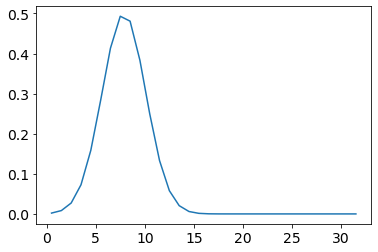

In [ ]:
plt.plot(x_coarse, make_gaussian(x_coarse, height=0.5))

In [ ]:
initial_state_gauss = {
    'concentration': c_init_guass.astype(np.float32),  # tensorflow code expects float32
    'x_velocity': np.ones(c_init_guass.shape, np.float32) * 1.0,
    'y_velocity': np.zeros(c_init_guass.shape, np.float32)
}

for k, v in initial_state_gauss.items():
  print(k, v.shape)

concentration (30, 32, 1)
x_velocity (30, 32, 1)
y_velocity (30, 32, 1)


In [ ]:
%time dr_nn_gauss = wrap_as_xarray(integrate.integrate_steps(model_nn, initial_state_gauss, time_steps))

CPU times: user 3.16 s, sys: 35.4 ms, total: 3.19 s
Wall time: 3.01 s


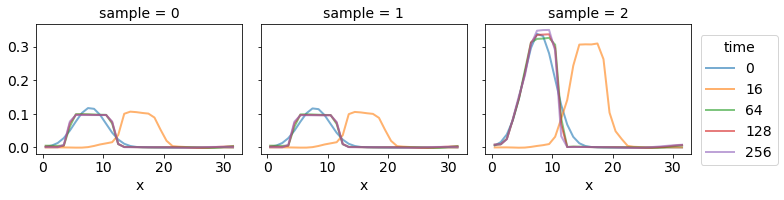

In [ ]:
(dr_nn_gauss.isel(time=[0, 16, 64, 128, 256], sample=[4, 10, 16])
.plot(hue='time', col='sample', alpha=0.6, linewidth=2)
)

Text(0.5, 1.05, 'Out-of-sample prediction')

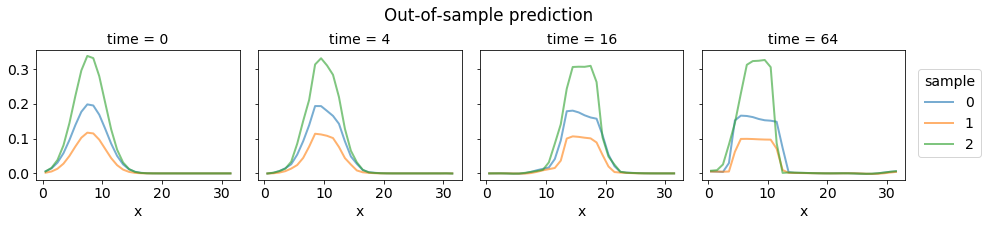

In [ ]:
(dr_nn_gauss.isel(time=[0, 4, 16, 64], sample=[0, 4, 16])
.plot(col='time', hue='sample', col_wrap=4, alpha=0.6, linewidth=2)
)
plt.suptitle('Out-of-sample prediction', y=1.05)

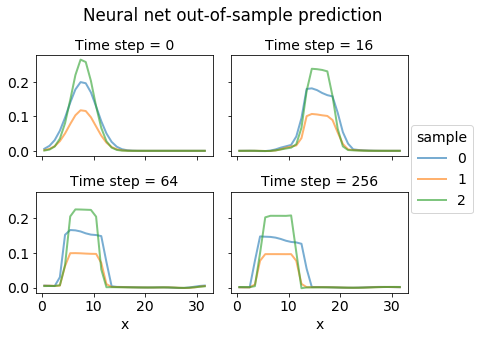

In [ ]:
(dr_nn_gauss.isel(time=[0, 16, 64, 256], sample=[0, 4, 29]).rename({'time': 'Time step'})
.plot(col='Time step', hue='sample', alpha=0.6, linewidth=2, col_wrap=2, figsize=[6, 4.5])
)
plt.suptitle('Neural net out-of-sample prediction', y=1.05)
plt.savefig('out-of-sample.png', dpi=288, bbox_inches='tight')

In [ ]:
# files.download('out-of-sample.png')